# Basic enzyme kinetics in drug design
### How to estimate IC50 values

In [1]:
% matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [3]:
plt.style.use('bmh')

#### Data from experiment
Concentrations were varied from 100 to 0.25nM. Results were inhibition at certain concentration

In [4]:
concentrations = [100.00,55.00,30.25,16.64,9.15,5.03,2.77,1.52,0.84,0.46,0.25,]
inhibitions = [0.9154582829,0.9025139059,0.8360481154,0.7489504283,0.6251563493,0.5068866746,
               0.3277214548,0.2411145656,0.1478374906,0.0722193139,0.0637565619]

In [5]:
df = pd.DataFrame()

In [6]:
df['c'] = concentrations
df['%inh'] = np.array(inhibitions)*100 # so that we have % inhibition

In [7]:
df

,c,%inh
0,100.00,91.545828
1,55.00,90.251391
2,30.25,83.604812
3,16.64,74.895043
4,9.15,62.515635
5,5.03,50.688667
6,2.77,32.772145
7,1.52,24.111457
8,0.84,14.783749
9,0.46,7.221931


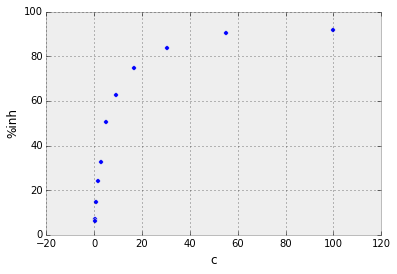

In [8]:
plt.scatter(df['c'], df['%inh'])
plt.xlabel('c')
plt.ylabel('%inh')

### How to calculate $IC_{50}$
$\log\left( {\%inh\over 100-\%inh} \right) = n\log({c}) - \log({Kd}).$

* n - Hill coefficient, ideally for classical competitive inhibitors equals to 1.  
* n > Positively cooperative binding
* n < Negatively cooperative binding
* High **n** values indicate **aggregators!** (Shoichet, J. Med. Chem. 2006, 49, 7274-7277)


In [9]:
df['logc'] = df['c'].map(np.log10)
df['%inh/(100-%inh)'] = df.apply(lambda x: np.log10(x['%inh']/(100-x['%inh'])), axis=1)

Sigmoid curve, **linear part from 20 to 80% inhibition**

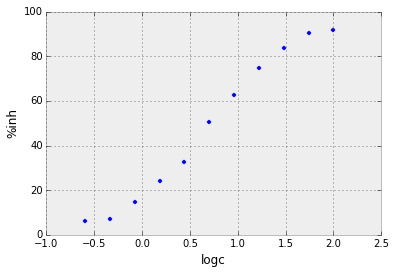

In [10]:
plt.scatter(df['logc'], df['%inh'])
plt.xlabel('logc')
plt.ylabel('%inh')

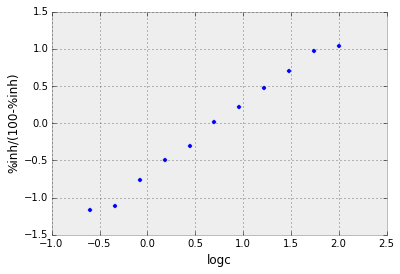

In [11]:
plt.scatter(df['logc'], df['%inh/(100-%inh)'])
plt.xlabel('logc')
plt.ylabel('%inh/(100-%inh)')

### Calculate slope (n) and intercept (-log(Kd))

For all points

In [12]:
slope, intercept, r_value, p, stderr = linregress(df['logc'], df['%inh/(100-%inh)'])
print("Slope: %f, intercept: %f and R-squared: %f" % (slope, intercept, r_value**2))

Slope: 0.916173, intercept: -0.681531 and R-squared: 0.993312


With linear part only

In [13]:
slope, intercept, r_value, p, stderr = linregress(list(df['logc'])[1:14], list(df['%inh/(100-%inh)'])[1:14])
print("Slope: %f, intercept: %f and R-squared: %f" % (slope, intercept, r_value**2))

Slope: 0.945964, intercept: -0.686931 and R-squared: 0.995574


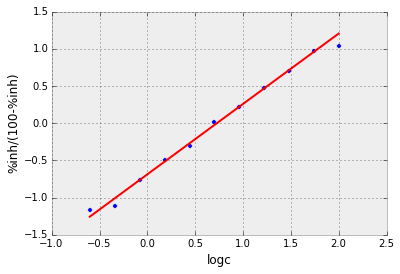

In [14]:
plt.scatter(df['logc'], df['%inh/(100-%inh)'])
plt.plot(df['logc'], df['logc']*slope + intercept, 'r')
plt.xlabel('logc')
plt.ylabel('%inh/(100-%inh)')

$\log\left( {\%inh\over 100-\%inh} \right) = k\log({c}) - \log({Kd}).$

$IC_{50}$ is the concentration at y = 0; $ 0 = 0.91*\log10(c) + 0.681531$

In [15]:
10**(0.681531/0.91)

5.609642242823899

In an ideal case with n=1 then $Kd=IC_{50}$.  
Kd:

In [16]:
10**0.681531

4.803203643499094

###And relation to Ki:
$K_i = \frac{IC_{50}}{1+\frac{[S]}{K_m}}$

Assuming [S] = Km

In [17]:
5.60964/(1+50/50)

2.80482

## Calculating $IC_{50}$ from one or two points
You have to make some assumptions
* n = 1, $IC_{50}$ = Kd
* you are in the linear part of the curve  
<br>
Equation then looks like:  
$IC_{50} = 10^{\log10(c)-\log10(\%inh/(100-\%inh))}$  
<br>
You can reduce it to:  
$IC_{50} = {c * (100-\%inh)\over \%inh}$

In [18]:
def calcIC50(c, inh):
    return c*(100-inh)/inh

In [19]:
df['IC50'] = df.apply(lambda x: calcIC50(x['c'],x['%inh']), axis = 1)

It works well except at the extremes. People would generally use the above assumptions if %inh is between 20 and 80%.

In [20]:
df

,c,%inh,logc,%inh/(100-%inh),IC50
0,100.00,91.545828,2.000000,1.034567,9.234907
1,55.00,90.251391,1.740363,0.966511,5.940889
2,30.25,83.604812,1.480725,0.707515,5.932128
3,16.64,74.895043,1.221153,0.474694,5.577759
4,9.15,62.515635,0.961421,0.222138,5.486339
5,5.03,50.688667,0.701568,0.011964,4.893323
6,2.77,32.772145,0.442480,-0.312044,5.682300
7,1.52,24.111457,0.181844,-0.497953,4.784057
8,0.84,14.783749,-0.075721,-0.760738,4.841915
9,0.46,7.221931,-0.337242,-1.108792,5.909487


In [21]:
def calc_inh(c, ic50):
    return 100*c/(ic50+c)

Data in [PKIS](https://www.ebi.ac.uk/chembldb/extra/PKIS/) is at two different concentrations (1 and 0.1 $\mu$M).  
In an ideal case %inh at higher concentration is around 80 and lower around 20%. Then you can use average of estimated IC50s.

In [22]:
calcIC50(1000, 80) # IC50

250

In [23]:
calc_inh(100, 250) # %inh

28

Potent inhibitors have $IC_{50} < 10 nM $ and even at 100 $\mu$M enzyme is completely inhibited (more than 90%) which means estimations are not very reliable because we are not in the linear part.

In [24]:
calc_inh(100, 2) # %inh

98

With this method and data points at 1 and 0.1 $\mu$M you still correctly calculate values for 25nM inhibitor

In [25]:
[(calc_inh(100,x),x) for x in range(0,30,5)]

[(100, 0), (95, 5), (90, 10), (86, 15), (83, 20), (80, 25)]

%inh higher than 80 are unreliable

In [26]:
calcIC50(100, 99.99) # IC50

0.010001000100015117

Safe estimation: $c/10$  
It is still obvious that you have a really potent inhibitor.


In [27]:
100/10

10

%inh higher lower than 20 are also unreliable

In [28]:
[(calc_inh(1000,x),x) for x in range(3000,6000,500)]

[(25, 3000), (22, 3500), (20, 4000), (18, 4500), (16, 5000), (15, 5500)]

Safe estimation: $c*10$  
Still obvious you have inactive compound

In [29]:
1000*10

10000

Now you understand why some data sets have pIC50s at the extremes always the same discrete value

In [30]:
np.log10(0.000001*10)

-5.0

## Final rules:
* %inh at lower concentration ~20 and at higher ~80: $IC_{50} = ({c_1 * (100-\%inh_1)\over \%inh_1}+{c_2 * (100-\%inh_2)\over \%inh_2})/2$
* %inh at one concentration between 20 and 80:  $IC_{50} = {c * (100-\%inh)\over \%inh}$
* %inh at lower concentration > 80: $c/10$, c = lowest c
* %inh at higher concentration < 20: $c*10$, c = highest c




Copyright (C) 2013, 2014 by Samo Turk, BioMed X GmbH

This work is licensed under the Creative Commons Attribution-ShareAlike 3.0 License. To view a copy of this license, visit http://creativecommons.org/licenses/by-sa/3.0/ or send a letter to Creative Commons, 543 Howard Street, 5th Floor, San Francisco, California, 94105, USA.
